##Importation des differents librairie

In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import re
from nltk.corpus import stopwords
from numpy import array
import nltk
import string
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D, Dropout, Conv1D, Flatten, Bidirectional
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


## Chargement du dataset allocine qui se trouve dans python ou aller directement sur le site pour le telecharger

In [ ]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 765.3 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
data = load_dataset("allocine")

Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
data.shape

{'train': (160000, 2), 'validation': (20000, 2), 'test': (20000, 2)}

In [ ]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})


## le préprocessing

In [6]:
# Accéder aux ensembles d'entraînement, de test et de validation
train_data = data['train']
test_data = data['test']
valid_data = data['validation']

In [7]:
# Accéder aux critiques et aux labels

reviews_train = train_data['review']
# Convertir train_reviews en DataFrame
df_reviews_train = pd.DataFrame(reviews_train, columns=['review'])


labels_train = train_data['label']
# Convertir train_dataset en DataFrame
df_train_labels = pd.DataFrame(labels_train, columns=['label'])

# Concaténer les deux DataFrames
df_train = pd.concat([df_reviews_train, df_train_labels], axis=1)

In [ ]:
##reviews_train[:10]

In [8]:
# Convertir test_reviews en DataFrame
test_reviews = test_data['review']
df_test_reviews = pd.DataFrame(test_reviews, columns=['review'])

# Convertir test_dataset en DataFrame
test_labels = test_data['label']
df_test_labels = pd.DataFrame(test_labels, columns=['label'])

# Concaténer les deux DataFrames
df_test = pd.concat([df_test_reviews, df_test_labels], axis=1)


In [9]:
# Convertir les validation en DataFrame
valid_reviews = valid_data['review']
df_valid_reviews = pd.DataFrame(valid_reviews, columns=['review'])

# Convertir valid_dataset['label'] en DataFrame
valid_labels = valid_data['label']
df_valid_labels = pd.DataFrame(valid_labels, columns=['label'])
# Concaténer les deux DataFrames
df_val = pd.concat([df_valid_reviews, df_valid_labels], axis=1)

In [ ]:
df_train.head(10)

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1
5,L'amnésie est un thème en or pour susciter le ...,0
6,Tout commence comme une comédie légère avant u...,1
7,un excellent film qui merite ses quatre étoile...,1
8,"Deuxième long métrage de Pasolini, Mamma Roma ...",1
9,Créateur de la célèbre série télévisée Kaamelo...,0


##Le nettoyage des données

In [10]:
# Téléchargement des ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re

def dataClining(texte, stopwords=None):
    # supprimer des liens hypertextes
    texte = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", texte)
    # supprimer des balises html
    texte = BeautifulSoup(text, "lxml").get_text()
    # remplacer les caractères autres que des lettres par des expaces
    text = re.sub("[^a-zA-Z]", " ", texte)
    return texte

In [12]:
def preprocessind_of_text(texte):
    # Tokenisation
    Tokenisation = word_tokenize(texte)
    # Suppression de la ponctuation et des caractères spéciaux
    Tokenisation = [word.lower() for word in Tokenisation if word.isalnum()]
    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words('french'))
    Tokenisation = [word for word in Tokenisation if not word in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    Tokenisation = [lemmatizer.lemmatize(word) for word in Tokenisation]
    # Reconstitution du texte prétraité
    preprocessed_text = ' '.join(Tokenisation)
    return preprocessed_text

In [13]:
# 1. Prétraitement des données
df_train['preprocessed_text'] = df_train['review'].apply(preprocessind_of_text)
df_test['preprocessed_text'] = df_test['review'].apply(preprocessind_of_text)
df_val['preprocessed_text'] = df_val['review'].apply(preprocessind_of_text)

In [ ]:
df_train.head(10)

,review,label,preprocessed_text
0,Si vous cherchez du cinéma abrutissant à tous ...,0,si cherchez cinéma abrutissant tous étages auc...
1,"Trash, re-trash et re-re-trash...! Une horreur...",0,trash horreur sans nom 20 premières minute ora...
2,"Et si, dans les 5 premières minutes du film, l...",0,si 5 premières minute film pathétique maquette...
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0,dieu quelle métaphore filée abasourdi réelleme...
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1,premier film saga kozure okami sabre vengeance...
5,L'amnésie est un thème en or pour susciter le ...,0,thème or susciter mystère encore être capable ...
6,Tout commence comme une comédie légère avant u...,1,tout commence comme comédie légère avant drame...
7,un excellent film qui merite ses quatre étoile...,1,excellent film merite quatre étoiles tellement...
8,"Deuxième long métrage de Pasolini, Mamma Roma ...",1,deuxième long métrage pasolini mamma rom conti...
9,Créateur de la célèbre série télévisée Kaamelo...,0,créateur célèbre série télévisée kaamelott ale...


In [ ]:
df_train['preprocessed_text']

0         si cherchez cinéma abrutissant tous étages auc...
1         trash horreur sans nom 20 premières minute ora...
2         si 5 premières minute film pathétique maquette...
3         dieu quelle métaphore filée abasourdi réelleme...
4         premier film saga kozure okami sabre vengeance...
                                ...                        
159995    rythme bien trop lent ashton kutcher bien trop...
159996    monsieur duchovny aussi piètre acteur réalisat...
159997    complètement différent film série conjuring no...
159998    alors franchement moment meilleur film noël ac...
159999    beur ville réunit toutes lacunes film français...
Name: preprocessed_text, Length: 160000, dtype: object

###  la baseline

In [14]:
# Convertir les textes en représentations vectorielles
Vcount = CountVectorizer()
X_train_counts = Vcount.fit_transform(df_train['preprocessed_text'])
X_test_counts = Vcount.transform(df_test['preprocessed_text'])


####bag-of-words

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialiser et entraîner le modèle de forêt aléatoire
rf_classifier_bow = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_bow.fit(X_train_counts, df_train['label'])

# Faire des prédictions sur l'ensemble de test
rf_predictions_bow = rf_classifier_bow.predict(X_test_counts)

# Évaluation des performances de notre modèle


accuracy = accuracy_score(df_test['label'], rf_predictions_bow)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(df_test['label'], rf_predictions_bow))


Accuracy: 0.8966
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10408
           1       0.90      0.89      0.89      9592

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [ ]:
# Régression logistique avec BoW
rl_classifierbow = LogisticRegression()
rl_classifierbow.fit(X_train_counts, df_train['label'])
rl_predictionsbow = rl_classifierbow.predict(X_test_counts)

print("Régression logistique avec Bag-of-Words :")
print("Accuracy:", accuracy_score(df_test['label'], rl_predictionsbow))
print("Classification Report:")
print(classification_report(df_test['label'], rl_predictionsbow))

Régression logistique avec Bag-of-Words :
Accuracy: 0.91865
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     10408
           1       0.91      0.92      0.92      9592

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



####TF-IDF

In [ ]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['preprocessed_text'])

# Régression logistique avec TF-IDF
lr_classifier_tfidf = LogisticRegression()
lr_classifier_tfidf.fit(X_train_tfidf, df_train['label'])
lr_predictions_tfidf = lr_classifier_tfidf.predict(X_test_tfidf)


print("Régression logistique avec TF-IDF :")
print("Accuracy:", accuracy_score(df_test['label'], lr_predictions_tfidf))
print("Classification Report:")
print(classification_report(df_test['label'], lr_predictions_tfidf))

Régression logistique avec TF-IDF :
Accuracy: 0.92225
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     10408
           1       0.91      0.93      0.92      9592

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [ ]:
# Random forest avec TF-IDF
nb_classifier_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
nb_classifier_tfidf.fit(X_train_tfidf, df_train['label'])
nb_predictions_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)

print("Random forest avec TF-IDF :")
print("Accuracy:", accuracy_score(df_test['label'], nb_predictions_tfidf))
print("Classification Report:")
print(classification_report(df_test['label'], nb_predictions_tfidf))

Random forest avec TF-IDF :
Accuracy: 0.89505
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10408
           1       0.89      0.89      0.89      9592

    accuracy                           0.90     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.90      0.90      0.90     20000



In [18]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', binary=True, unicode_errors="ignore")

In [19]:
def encode_text(text, model):
    word_vectors = []
    for word in text.split():
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Itérer sur les valeurs de la colonne 'preprocessed_text'
encoded_texts = []
for text in df_train['preprocessed_text']:
    encoded_texts.append(encode_text(text, model))


In [19]:
# Afficher les vecteurs encodés
for encoded_text in encoded_texts:
    print("Vecteur encodé:", encoded_text)


## Modele training

## LSTM

In [20]:
# Définir les paramètres du modèle
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 64  # Dimension de l'embedding
max_length = 200  # Longueur maximale d'une critique
num_classes = 2  # Nombre de classes (positive/négative)

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialiser le tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Adapter le tokenizer aux critiques d'entraînement
tokenizer.fit_on_texts(df_train['preprocessed_text'].values)

# Tokeniser les critiques d'entraînement et de test validation
X_train = tokenizer.texts_to_sequences(df_train['preprocessed_text'].values)
X_test = tokenizer.texts_to_sequences(df_test['preprocessed_text'].values)
X_val = tokenizer.texts_to_sequences(df_val['preprocessed_text'].values)

# Remplir les séquences pour qu'elles aient toutes la même longueur
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
# Remplir les séquences pour qu'elles aient toutes la même longueur
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

In [22]:
from keras.utils import to_categorical
y_train = to_categorical(df_train['label'])
y_test = to_categorical(df_test['label'])

### Bidirectional

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional


# Créer le modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(num_classes, activation='softmax'))

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 706306 (2.69 MB)
Trainable params: 706306 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)

Epoch 1/8
2500/2500 [==============================] - 146s 56ms/step - loss: 0.2461 - accuracy: 0.8994 - val_loss: 0.1915 - val_accuracy: 0.9243
Epoch 2/8
2500/2500 [==============================] - 53s 21ms/step - loss: 0.1778 - accuracy: 0.9293 - val_loss: 0.1810 - val_accuracy: 0.9283
Epoch 3/8
2500/2500 [==============================] - 46s 18ms/step - loss: 0.1493 - accuracy: 0.9414 - val_loss: 0.1852 - val_accuracy: 0.9281
Epoch 4/8
2500/2500 [==============================] - 44s 18ms/step - loss: 0.1214 - accuracy: 0.9537 - val_loss: 0.1903 - val_accuracy: 0.9270
Epoch 5/8
2500/2500 [==============================] - 42s 17ms/step - loss: 0.0981 - accuracy: 0.9636 - val_loss: 0.2088 - val_accuracy: 0.9280
Epoch 6/8
2500/2500 [==============================] - 43s 17ms/step - loss: 0.0760 - accuracy: 0.9725 - val_loss: 0.2327 - val_accuracy: 0.9262
Epoch 7/8
2500/2500 [==============================] - 45s 18ms/step - loss: 0.0596 - accuracy: 0.9793 - val_loss: 0.2879 - val_a

### Evaluation la performance des différents modèles

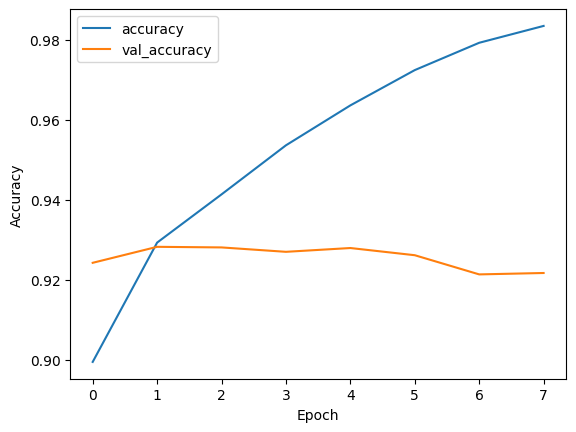

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

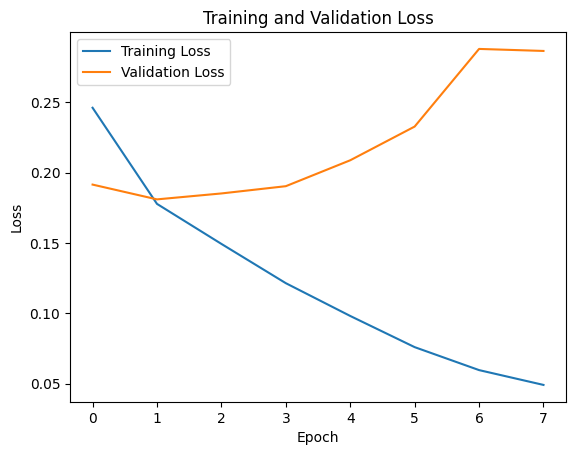

In [26]:
# Tracer les courbes de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = cnn_lstm_model.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, X_test)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

625/625 [==============================] - 5s 9ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass-multioutput targets

In [34]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length=max_length))
cnn_lstm_model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Bidirectional(LSTM(64)))
cnn_lstm_model.add(Dense(num_classes, activation='softmax'))
cnn_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 32)           10272     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 100, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 256)          

In [35]:
# Compiler le modèle
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Entraîner le modèle
history = cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Évaluer le modèle sur les données de test
test_loss, test_accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
2500/2500 [==============================] - 117s 41ms/step - loss: 0.2225 - accuracy: 0.9070 - val_loss: 0.1793 - val_accuracy: 0.9280
Epoch 2/10
2500/2500 [==============================] - 46s 18ms/step - loss: 0.1493 - accuracy: 0.9427 - val_loss: 0.1725 - val_accuracy: 0.9326
Epoch 3/10
2500/2500 [==============================] - 51s 20ms/step - loss: 0.1014 - accuracy: 0.9635 - val_loss: 0.2037 - val_accuracy: 0.9291
Epoch 4/10
2500/2500 [==============================] - 45s 18ms/step - loss: 0.0612 - accuracy: 0.9797 - val_loss: 0.2538 - val_accuracy: 0.9230
Epoch 5/10
2500/2500 [==============================] - 41s 16ms/step - loss: 0.0385 - accuracy: 0.9875 - val_loss: 0.2791 - val_accuracy: 0.9230
Epoch 6/10
2500/2500 [==============================] - 42s 17ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.3022 - val_accuracy: 0.9215
Epoch 7/10
2500/2500 [==============================] - 41s 16ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.3024 

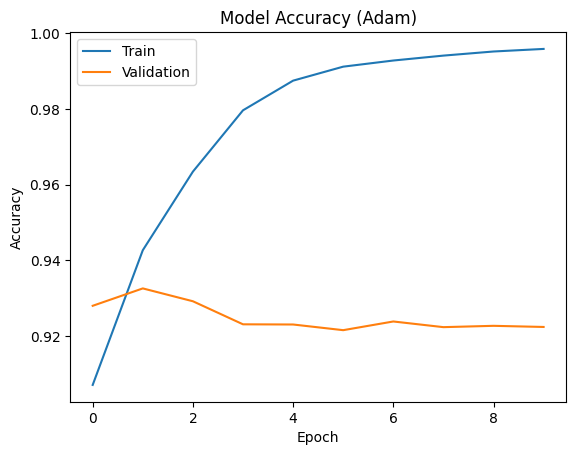

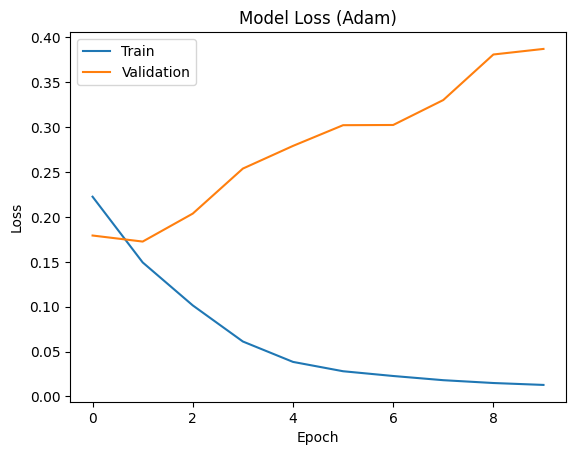

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values (Adam)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Adam)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values (Adam)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Adam)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
# Définir les dimensions
vocab_size = 10000  # Taille du vocabulaire
embed_dim = 64  # Dimension de l'embedding
lstm_out = 200  # Longueur maximale d'une critique
num_classes = 2  # Nombre de classes (positive/négative)

# Créer le modèle
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=lstm_out))
model.add(Dropout(0.8))  # Ajouter un dropout
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

# Afficher le résumé du modèle
print(model.summary())

# Sauvegarder une représentation graphique du modèle
#plot_model(model, to_file='model.png')

# Entraîner le modèle (assurez-vous d'avoir défini X_train et y_train auparavant)
history = cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Évaluer le modèle (assurez-vous d'avoir défini X_test et y_test auparavant)
score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=32)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 64)           640000    
                                                                 
 dropout_4 (Dropout)         (None, 200, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 200)               212000    
                                                                 
 dense_5 (Dense)             (None, 2)                 402       
                                                                 
Total params: 852402 (3.25 MB)
Trainable params: 852402 (3.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
2500/2500 [==============================] - 43s 17ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.4195 - val_accuracy: 0.9186

In [48]:
from sklearn.metrics import confusion_matrix

y_val = to_categorical(df_val['label'])
# Prédiction sur les données de validation pour le modèle RMSprop
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype('int')  # Conversion en classes
conf_matrix_ = confusion_matrix(y_val, y_pred)
print("Matrice de confusion pour le modèle RMSprop :\n", conf_matrix)

625/625 [==============================] - 43s 68ms/step


ValueError: multilabel-indicator is not supported